# Expectation vs Variance of Average Treatment Effect

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from agm import calibrateAnalyticGaussianMechanism
from matplotlib import cm

%matplotlib inline

# set random seed
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# no. experiments, no. samples, dim, X
ne = 100
ns = 1000
d  = 5
X  = torch.randn(ne, ns, d, dtype=torch.float64)

In [3]:
# restrict X to ||x||_2 \leq 1 to fit assumption
X = X / X.norm(dim=2).max()

In [4]:
# vectors for generating Y, differentiate between Y_0 and Y_1 with bias
# Y = beta^T X + 0.1 Z
# Y_1 = Y + bias, Y_0 = Y
beta = torch.tensor([0.1,0.2,0.3,0.4,0.5], dtype=torch.float64).reshape((-1, 1))
biases = [0, 0.5, 1, 1.5, 2]

In [5]:
# generate Y
Y = torch.einsum('kl,ijk->ij',beta,X) + 0.1 * torch.randn(ne, ns, dtype=torch.float64)

In [6]:
# vectors for generating T
# T = exp(-T_w^T X + b)
T_w = torch.tensor([0.5,0.4,0.3,0.2,0.1], dtype=torch.float64).reshape((-1, 1))
T_b = 0 # 0.05

In [7]:
# privacy parameters
epses = [0.5]
delta = 1. / (ns ** 2)

# regularisation coefficient
reg_co = 0.1

# splits
n_splits = 2

In [8]:
class Log_Reg(torch.nn.Module):
    '''
    Logistic Regression
    '''
    def __init__(self, D_in, D_out):
        super(Log_Reg, self).__init__()
        self.linear = torch.nn.Linear(D_in, D_out, bias=False)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [9]:
def inv_pro_weight_priv_pro_score(X, T, prob_vec, Y, bias, epses, delta, reg_co, n_splits):
    '''
    estimate treatment effect with inverse propensity weighting using private propensity scores
    '''
    # get # experiments, # samples, # dimensions
    ne, ns, d = X.shape
    
    # sgd step size
    step_size = 0.01
    
    ################
    # process data #
    ################
    
    # get Y0 and Y1
    Y0 = Y * (1 - T)
    Y1 = (Y + bias) * T
    
    # split data
    # get split size
    split_size = int(ns / n_splits)

    # permutate indices
    perm = torch.stack([torch.randperm(ns) for i in range(ne)])

    # create splits
    s0 = perm[:, :split_size]
    s1 = perm[:, split_size:]

    # create auxiliary indices
    ind = torch.arange(ne)[:, None]

    # split X into fit, estimate splits
    X_s0 = X[ind, s0]
    X_s1 = X[ind, s1]

    # expand dim of T to allow multiplication with X
    T_ex_dim = T.reshape(ne, ns, 1)

    # split X0 and X1 into fit, estimate splits
    X0_s1 = (X * (1- T_ex_dim))[ind, s1]
    X1_s1 = (X * T_ex_dim)[ind, s1]

    # precompute ||X0_sl||_2^2 and ||X1_sl||_2^2
    X0_s1_2 = X0_s1.norm(dim=2) ** 2
    X1_s1_2 = X1_s1.norm(dim=2) ** 2

    # add x_i to x_j for X0_plus_X0_s1 and X1_plus_X1_s1
    X0_plus_X0_s1 = X0_s1.reshape(ne, split_size, 1, d) + X0_s1.reshape(ne, 1, split_size, d)
    X1_plus_X1_s1 = X1_s1.reshape(ne, split_size, 1, d) + X1_s1.reshape(ne, 1, split_size, d)

    # get norms squared for X0_plus_X0_s1 and X1_plus_X1_sl
    X0_plus_X0_sl_norm_2 = X0_plus_X0_s1.norm(dim=-1) ** 2 
    X1_plus_X1_sl_norm_2 = X1_plus_X1_s1.norm(dim=-1) ** 2 

    # split T into fit, estimate splits
    T_s0 = T[ind, s0]
    T_s1 = T[ind, s1]

    # split Y0 and Y1 into fit, estimate splits 
    Y0_s0 = Y0[ind, s0] 
    Y1_s0 = Y1[ind, s0] 

    Y0_s1 = Y0[ind, s1] 
    Y1_s1 = Y1[ind, s1] 

    # mult y_i to y_j for Y0_times_Y0_s1 and Y1_times_Y1_s1
    Y0_times_Y0_s1 = Y0_s1.reshape(ne, split_size, 1) * Y0_s1.reshape(ne, 1, split_size)
    Y1_times_Y1_s1 = Y1_s1.reshape(ne, split_size, 1) * Y1_s1.reshape(ne, 1, split_size)

    ##############
    # fit models #
    ##############

    # instantiate ne different models
    models = [Log_Reg(d, 1) for i in range(ne)]
    # set model parameters to float64
    [model.double() for model in models]

    # define loss (binary cross entropy)
    loss = torch.nn.BCELoss()

    # define optimisers
    optimisers = [torch.optim.SGD(models[i].parameters(), lr=step_size, weight_decay=reg_co) for i in range(ne)]
    
    # train model
    for t in range(1000):
        preds = [models[i](X_s0[i]).squeeze() for i in range(ne)]
        losses = [loss(preds[i], T_s0[i]) for i in range(ne)]
        [opt.zero_grad for opt in optimisers]
        [loss.backward() for loss in losses]
        [opt.step() for opt in optimisers]    
        
    #############################    
    # estimate treatment effect #
    #############################
    
    # initialise pi_hat dictionaries 
    pi_hats = {} 
    pi_hats_analytic = {}
    
    # get estimated propensity scores
    pi_hats[0] = torch.stack([models[i](X_s1[i]).squeeze() for i in range(ne)])

    # perturb model and get relevant quantities
    for eps in epses:
        # define sigma
        s_a = 2. / (split_size * reg_co)

    #     # gaussian mechanism
    #     sigma = np.sqrt(2 * np.log(1.25 / delta) + 1e-6) *  (s_a  / eps)
    #     sigma_2 = sigma ** 2

        # analytic gaussian mechanism
        sigma = calibrateAnalyticGaussianMechanism(eps, delta, s_a)
        sigma_2 = sigma ** 2

        # define noise distribution
        noise_dist = torch.distributions.normal.Normal(torch.tensor([0.0], dtype=torch.float64), torch.tensor([sigma], dtype=torch.float64))

        # draw noise vectors
        noise_vecs = noise_dist.sample((ne, d)).squeeze()
        # noise_vecs = noise_dist.sample((ne, d+1)).squeeze()

        # create temp models 
        models_ = copy.deepcopy(models)

        # \hat{\w}^\top Xs
        w_T_X0_s1 = []
        w_T_X0_plus_X0_s1 = []
        w_T_X1_s1 = []
        w_T_X1_plus_X1_s1 = []

        # perturb weights with noise vectors
        for i in range(ne):
            w_T_X0_s1.append(torch.einsum('ij,kj-> i', X0_s1[i], models[i].linear.weight))
            w_T_X0_plus_X0_s1.append(torch.einsum('ijk,lk-> ij', X0_plus_X0_s1[i], models[i].linear.weight))
            w_T_X1_s1.append(torch.einsum('ij,kj-> i', X1_s1[i], models[i].linear.weight))
            w_T_X1_plus_X1_s1.append(torch.einsum('ijk,lk-> ij', X1_plus_X1_s1[i], models[i].linear.weight))
            # w_T_X.append(torch.einsum('ij,kj-> i', X[i], models[i].linear.weight) + models[i].linear.bias)
            models_[i].linear.weight.data.add_(noise_vecs[i][:d])
            # models_[i].linear.bias.data.add_(noise_vecs[i][d:])

        # precompute sigma^2 ||x||_2^2 and \w^\top Xs
        pi_hats_analytic[eps] = {'sigma_2_X0_s1_2': sigma_2 * X0_s1_2}
        pi_hats_analytic[eps]['sigma_2_X1_s1_2'] = sigma_2 * X1_s1_2
        pi_hats_analytic[eps]['sigma_2_X0_plus_X0_s1'] = sigma_2 * X0_plus_X0_sl_norm_2
        pi_hats_analytic[eps]['sigma_2_X1_plus_X1_s1'] = sigma_2 * X1_plus_X1_sl_norm_2
        pi_hats_analytic[eps]['w_T_X0_s1'] = torch.stack(w_T_X0_s1)
        pi_hats_analytic[eps]['w_T_X0_plus_X0_s1'] = torch.stack(w_T_X0_plus_X0_s1)
        pi_hats_analytic[eps]['w_T_X1_s1'] = torch.stack(w_T_X1_s1)
        pi_hats_analytic[eps]['w_T_X1_plus_X1_s1'] = torch.stack(w_T_X1_plus_X1_s1)

        # get estimated privatised propensity scores
        pi_hats[eps] = torch.stack([models_[i](X_s1[i]).squeeze() for i in range(ne)])
    
    # get treatment effects
    # true
    te = {}
    # empirical means and std of means of ERM + noise 
    te_hats = {'mean': [], 'std': []}
    # analytic means and std of ERM + noise
    te_hats_analytic = {'mean': [], 'std': []}

    # estimate true treatment effect
    te_ = torch.mean(Y1_s1 / prob_vec[ind, s1] - Y0_s1 / (1 - prob_vec[ind, s1]), 1)
    te['mean'] = te_.mean().detach().numpy()
    te['std'] = te_.std().detach().numpy()

    for key in pi_hats.keys():
        te_hats_ = torch.mean(Y1_s1 / pi_hats[key] - Y0_s1 / (1 - pi_hats[key]), 1)
        te_hats['mean'].append(te_hats_.mean().detach().numpy())
        te_hats['std'].append(te_hats_.std().detach().numpy())
        if key != 0:
            # expectation and variance of mu_1
            rand_mu_0 = Y0_s1 * torch.exp(pi_hats_analytic[key]['w_T_X0_s1'] + pi_hats_analytic[key]['sigma_2_X0_s1_2']/2)
            E_mu_0 = torch.mean(Y0_s1 + rand_mu_0, 1)
            mu_X0_s1_2 = Y0_times_Y0_s1 * torch.exp(pi_hats_analytic[key]['w_T_X0_plus_X0_s1'] + pi_hats_analytic[key]['sigma_2_X0_plus_X0_s1']/2)
            mu_X0_s1_mu_X0_s1 = rand_mu_0.reshape(ne, split_size, 1) * rand_mu_0.reshape(ne, 1, split_size)
            var_mu_0 = torch.mean(mu_X0_s1_2 - mu_X0_s1_mu_X0_s1, [1, 2])
            # expectation and variance of mu_1
            rand_mu_1 = Y1_s1 * torch.exp(- pi_hats_analytic[key]['w_T_X1_s1'] + pi_hats_analytic[key]['sigma_2_X1_s1_2']/2)
            E_mu_1 = torch.mean(Y1_s1 + rand_mu_1, 1)
            mu_X1_s1_2 = Y1_times_Y1_s1 * torch.exp(- pi_hats_analytic[key]['w_T_X1_plus_X1_s1'] + pi_hats_analytic[key]['sigma_2_X1_plus_X1_s1']/2)
            mu_X1_s1_mu_X1_s1 = rand_mu_1.reshape(ne, split_size, 1) * rand_mu_1.reshape(ne, 1, split_size)
            var_mu_1 = torch.mean(mu_X1_s1_2 - mu_X1_s1_mu_X1_s1, [1, 2])
            # expectation and variance of te_hats
            te_hats_analytic_mu = E_mu_1 - E_mu_0
            te_hats_analytic_std = torch.sqrt(var_mu_1 + var_mu_0)
            te_hats_analytic['mean'].append(te_hats_analytic_mu.detach().numpy())
            te_hats_analytic['std'].append(te_hats_analytic_std.detach().numpy())

    te_hats['mean'] = np.array(te_hats['mean'])
    te_hats['std'] = np.array(te_hats['std'])
    te_hats_analytic['mean'] = np.array(te_hats_analytic['mean'])
    te_hats_analytic['std'] = np.array(te_hats_analytic['std'])
    
    return te, te_hats, te_hats_analytic

In [10]:
def plot_mean_var(data):
    '''
    plot mean, var, log (var / mean^2)
    '''
    
    fig, ax = plt.subplots(1,1, figsize=(20, 10))

    sns.lineplot(x='bias', y='mean', data=data, marker='o', color='magenta', label="Mean")
    sns.lineplot(x='bias', y='var', data=data, marker='*', color='red', label="Variance")
    sns.lineplot(x='bias', y='log_var_div_mean_2', data=data, marker='x', color='blue', label="log(Variance / Mean^2)")

    ax.set_title("Mean, Variance, log(Variance / Mean^2) of Average Treatment Effect", fontsize=16)
    ax.set_xlabel("Bias", fontsize=16)
    ax.set_ylabel("", fontsize=16)
    ax.legend()

    fig.tight_layout()
    fig.savefig('sim_bias_mean_var.png',dpi=100)

## Model $(\mathbb{E}[\mu_1 - \mu_0] >= 0)$

In [11]:
# generate T \in {0, 1}
prob_vec = torch.sigmoid(torch.einsum('kl,ijk->ij', T_w, X) + T_b)
T = torch.bernoulli(prob_vec)

In [12]:
mean = {}
var = {}

# run across biases
for bias in biases:
    Y0 = Y * (1 - T)
    Y1 = (Y + bias) * T
    _, _, te_hats_analytic = inv_pro_weight_priv_pro_score(X, T, prob_vec, Y, bias, epses, delta, reg_co, n_splits)
    mean[bias] = te_hats_analytic['mean'].squeeze()
    var[bias] = (te_hats_analytic['std'] ** 2).squeeze()

In [13]:
# get dataframes for seaborn
df_mean = (
    pd.DataFrame.from_dict(mean)
    .unstack()
    .reset_index()
    .drop('level_1', 1)
    .rename(
        index=str, columns={'level_0': 'bias', 0: 'mean'}
    )
)
df_var = (
    pd.DataFrame.from_dict(var)
    .unstack()
    .reset_index()
    .drop('level_1', 1)
    .rename(
        index=str, columns={'level_0': 'bias_', 0: 'var'}
    )
)

df = (
    pd.concat([df_mean, df_var], join='inner', axis=1)
    .drop('bias_', 1)
)

df['log_var_div_mean_2'] = np.log(df['var'] / (df['mean'] ** 2))

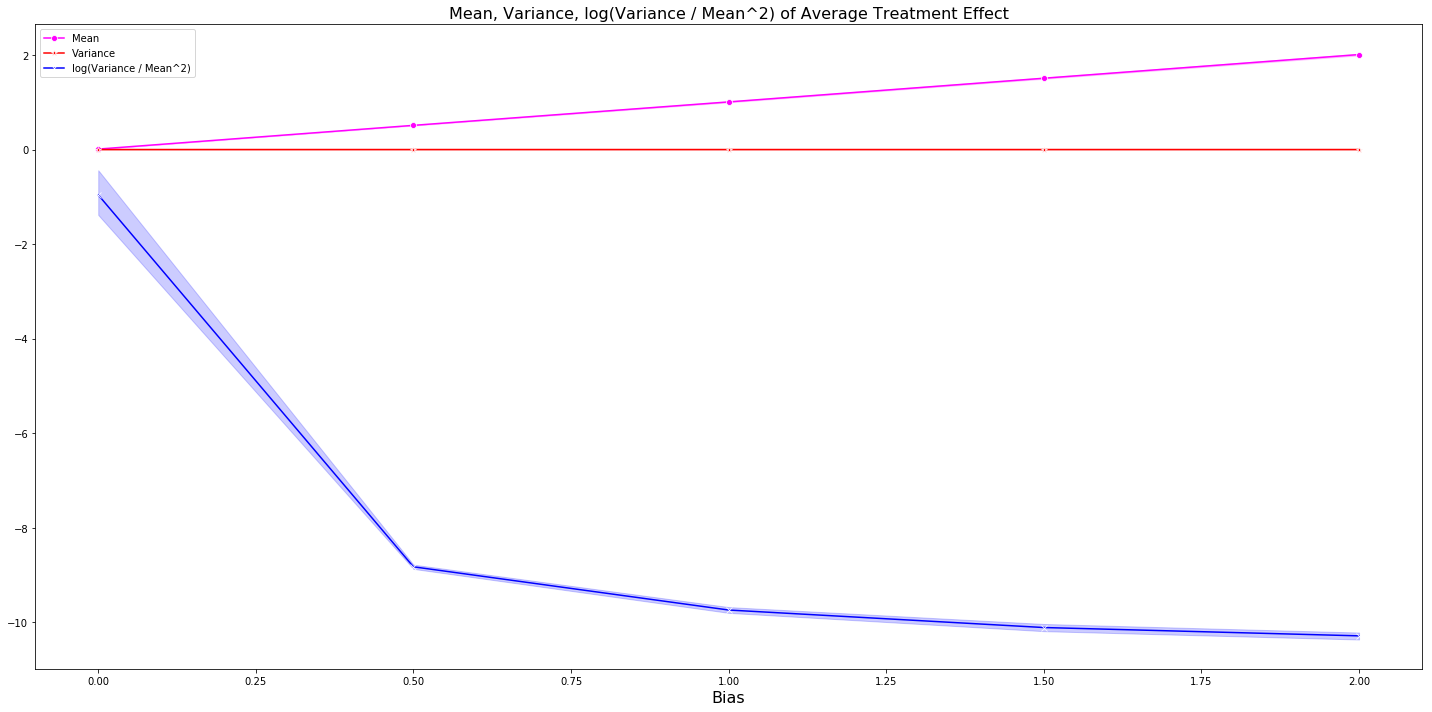

In [14]:
plot_mean_var(df)